In [51]:
import moments
import demes
import gzip
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import itertools

In [2]:
# Get the observed SFS
# Load the intergenic SNPs

data = '../../data/220113-ConstructBoostrapedDatasets/data/whole-genome/spectrum-cat_intergenic.pkl.gz'

with gzip.open(data, "rb") as f:
    data = pickle.load(f)


In [3]:
data = data.project([20]*4)

In [4]:
# Get expected SFS under the model
mdl = '../220124-InfereModels/results/best-guest-NAT-EXPANSION-intergenic.yml'
mdl = demes.load(mdl)

expected_sfs = moments.Spectrum.from_demes(
    mdl,
    sampled_demes=data.pop_ids,
    sample_sizes=[20] * 4
)

In [8]:
expected_sfs = moments.Inference.optimally_scaled_sfs(expected_sfs, data)

In [43]:
def marginalize(sf, pop_pair):
    idx_to_marinalize = [i for i in range(4) if sf.pop_ids[i] not in pop_pair]
    sf_marginalized = sf.marginalize(idx_to_marinalize)
    return sf_marginalized


def put_in_a_table(twoD_sfs):
    pop1, pop2 = twoD_sfs.pop_ids
    N = twoD_sfs.shape[0]
    cols = [pop2 + '_' + str(x) for x in range(N)]
    rows = [pop1 + '_' + str(x) for x in range(N)]
    d = pd.DataFrame(twoD_sfs._data, columns=cols)
    d['Pop1'] = rows
    return d
    

In [44]:
def get_resid_data(pop_pair):
    
    data_2d = marginalize(data, pop_pair)
    model_2d = marginalize(expected_sfs, pop_pair)
    residual = moments.Inference.Anscombe_Poisson_residual(model_2d, data_2d)
    
    data_2d = put_in_a_table(data_2d)
    model_2d = put_in_a_table(model_2d)
    residual = put_in_a_table(residual)
    data_2d['Pops'] = '-'.join(pop_pair)
    model_2d['Pops'] = '-'.join(pop_pair)
    residual['Pops'] = '-'.join(pop_pair)
    
    out_name = lambda x:f'results/{pop_pair[0]}_{pop_pair[1]}-{x}.csv'

    data_2d.to_csv(out_name('data'), index=False)
    model_2d.to_csv(out_name('model'), index=False)
    residual.to_csv(out_name('residuals'), index=False)


In [45]:
all_pairs = list(itertools.combinations(data.pop_ids, 2))
[get_resid_data(x) for x in all_pairs]

[None, None, None, None, None, None]

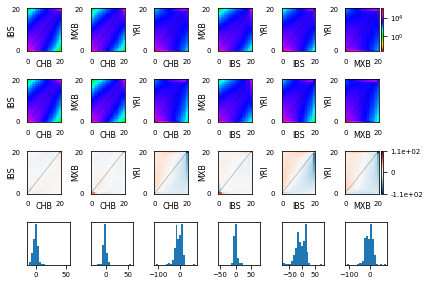

In [57]:
moments.Plotting.plot_4d_comp_Poisson(expected_sfs, data, out='results/moments-resid.pdf')
